In [1]:
import dill
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [22]:
# loading the run for the HMM model fit for mouse 1

dill.load_module('/Users/varshinisubramanian/Desktop/CMU/Yttri Lab Research/No Conflict Low Volatility (control)/Mouse Runs (pt. 2)/mouse_9_run.db')

In [23]:
# printing the means

best_model.means_

array([[0.17408234, 0.98815119, 0.98786268],
       [0.10905774, 0.68174037, 0.51052857],
       [0.16849977, 0.59505897, 0.59413449],
       [0.20285418, 0.94333734, 0.92651074],
       [0.12700123, 0.87470243, 0.47400922]])

<Axes: >

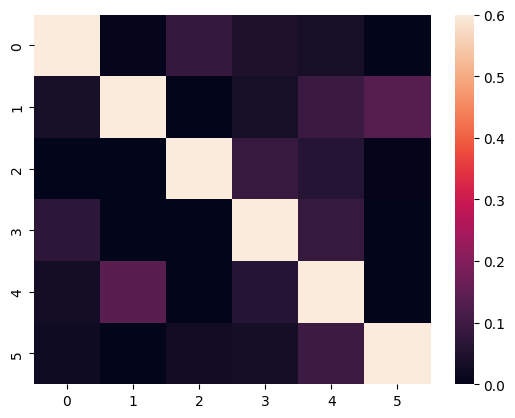

In [4]:
# visual representation of transmat

sns.heatmap(best_model.transmat_, vmin=0, vmax=0.6)

In [116]:
# transmat

print(np.round(best_model.transmat_,2))

[[0.83 0.01 0.08 0.05 0.04 0.  ]
 [0.04 0.69 0.   0.04 0.09 0.13]
 [0.   0.   0.85 0.09 0.06 0.  ]
 [0.07 0.   0.   0.84 0.09 0.  ]
 [0.03 0.14 0.   0.06 0.77 0.  ]
 [0.02 0.   0.03 0.03 0.1  0.82]]


In [5]:
print(best_model.transmat_)

[[8.28108836e-001 5.01297059e-003 8.43704113e-002 4.59287317e-002
  3.65790499e-002 7.76089364e-037]
 [3.87618916e-002 6.94857874e-001 1.69897654e-003 3.70705649e-002
  9.37393064e-002 1.33871386e-001]
 [5.38332593e-130 7.13339662e-056 8.50509909e-001 8.72301045e-002
  5.95432408e-002 2.71674603e-003]
 [7.20245405e-002 4.45756954e-034 6.52031255e-004 8.40596477e-001
  8.59688144e-002 7.58136450e-004]
 [3.04085636e-002 1.38944267e-001 7.56362181e-004 6.04837974e-002
  7.69407009e-001 1.19834947e-017]
 [2.17805162e-002 1.51285504e-133 2.65587413e-002 3.29210271e-002
  9.61512238e-002 8.22588492e-001]]


In [117]:
# resetting index to make the next step easier (mouse_indiv is the fully altered dataframe from HMM fitting)

mouse_indiv.reset_index(drop=True, inplace=True)

In [118]:
# calculating moving average of correct unrewarded/rewarded actions, and a binary vector of transitions 

correct_and_unr = []
correct_and_r = []
incorr_and_unr = []
state_transition = []

for index, row in mouse_indiv.iterrows():
    if row['event_marker'] == 2.0 or row['event_marker'] == 6.0: correct_and_unr.append(1)
    else: correct_and_unr.append(0)

    if row['event_marker'] == 1.0 or row['event_marker'] == 5.0: correct_and_r.append(1)
    else: correct_and_r.append(0)

    if row['event_marker'] == 4.0 or row['event_marker'] == 8.0: incorr_and_unr.append(1)
    else: incorr_and_unr.append(0)
    
    if index == 0: state_transition.append(0)
    else: 
        #print(row['state'], mouse_indiv.loc[int(index) - 1, 'state'])
        if row['state'] == 4 and mouse_indiv.loc[int(index) - 1, 'state'] == 5: state_transition.append(1)
        else: state_transition.append(0)

correct_and_unr_mv = pd.Series(correct_and_unr).ewm(span=1).mean()
correct_and_r_mv = pd.Series(correct_and_r).ewm(span=1).mean()
block_change_mv = mouse_indiv['block_change'].ewm(span=1).mean()
incorr_and_unr_mv = pd.Series(incorr_and_unr).ewm(span=1).mean()

In [119]:
# creating a new DataFrame for the calculated measures for the model 

data_for_model = pd.DataFrame()
data_for_model["correct_unrew"]  = correct_and_unr_mv
data_for_model["correct_rew"]  = correct_and_r_mv
data_for_model['incorr_unrew'] = incorr_and_unr_mv
data_for_model["block_change"] = block_change_mv
data_for_model["state_transition"] = state_transition
data_for_model["dec_time_diff"] = np.concatenate(([0], np.diff(mouse_indiv['dec_time'])))
data_for_model["trial_num"] = np.arange(len(state_transition))

data_for_model['correct_rew_diff'] = np.concatenate(([0], np.diff(correct_and_r_mv)))
data_for_model['correct_unrew_diff'] = np.concatenate(([0], np.diff(correct_and_unr_mv)))
data_for_model['incorr_unrew_diff'] = np.concatenate(([0], np.diff(incorr_and_unr_mv)))


In [120]:
# data_for_model['incorr_unrew'] = data_for_model['incorr_unrew'] - np.mean(data_for_model['incorr_unrew'])
# data_for_model['incorr_unrew'][data_for_model['incorr_unrew'] < 0] = 0

In [121]:
# splitting data into train and test

y = data_for_model['state_transition']
X = data_for_model.drop(columns=['state_transition'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [122]:
weights = compute_class_weight(class_weight='balanced',y=y,classes=np.unique(y))

In [123]:
var_weights = [weights[i] for i in y_train]
model = sm.GLM(y_train, X_train, var_weights=var_weights, family=sm.families.Binomial(link=sm.families.links.logit()))
results = model.fit()

print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:       state_transition   No. Observations:                 3860
Model:                            GLM   Df Residuals:                     3852
Model Family:                Binomial   Df Model:                            7
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -530.00
Date:                Fri, 18 Aug 2023   Deviance:                       1060.0
Time:                        15:02:35   Pearson chi2:                 3.67e+03
No. Iterations:                    27   Pseudo R-squ. (CS):             0.6674
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
correct_unrew        -26.1271   6.92

/opt/homebrew/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The logit link alias is deprecated. Use Logit instead. The logit link alias will be removed after the 0.15.0 release.
  warnings.warn(


(500.0, 1000.0)

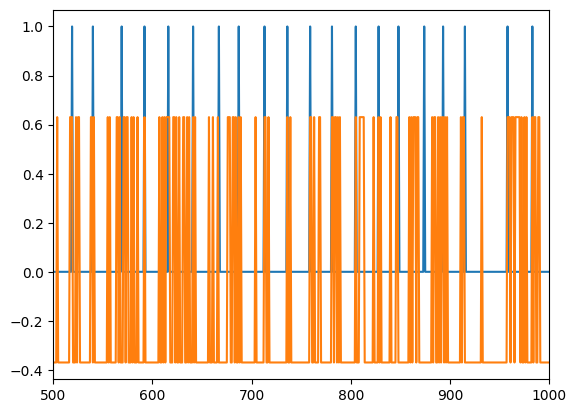

In [124]:
import matplotlib.pyplot as plt

plt.plot(np.arange(len(data_for_model)), data_for_model["block_change"])
plt.plot(np.arange(len(data_for_model)), data_for_model["incorr_unrew"] - np.mean(data_for_model["incorr_unrew"]))
#plt.plot(np.arange(len(data_for_model)), data_for_model["correct_unrew"])
plt.xlim(500, 1000)

In [125]:
y_pred_glm = results.predict(X_test)
y_pred_bin = []

for i in y_pred_glm: 
    if i < 0.5: y_pred_bin.append(0)
    else: y_pred_bin.append(1)

print(f"Accuracy: {accuracy_score(y_test, y_pred_bin)}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_bin)}")

Accuracy: 0.947940947940948
Confusion Matrix:
[[1209   67]
 [   0   11]]
